## Quick tests regarding CCD fitting

### Fernando Gutiérrez-Canales
#### 4 / May / 2023

In [1]:
#Let's import the main libraries and modules
import glob
import os
import numpy as np
from numpy import unravel_index
from astropy.io import fits
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------
# CONFIGURATION PARAMETERS
#dataDIR = '/home/fgutierrez/CCD_testing/flat-633nm_0001/' # at lab laptop
#DIRout = '/home/fgutierrez/CCD_testing/pre_processed_ccd_tests/' # at lab laptop
dataDIR = '/home/fercho/Documents/PhD/CCD/PLATO_CCD_CTI/flat-633nm_0001/'
DIRout = '/home/fercho/Documents/PhD/CCD/PLATO_CCD_CTI/results_at_ESTEC/'
gain = 25                                                 # conversion factor from adu to e-
fsize = 14                                                # fontsize for the plots
# --------------------------------------------------------------------------------------------

### Now it is time to create a list with the names of the fits files of a given value of integration time of the measurements (as of August 8, 2023, Dr. Peter Verhoeve told me that  the 'int' in the file names is actually referring to 'integration time' and not 'intensity')

In [3]:
# First we create a list containing the names of all the fits files with a given integration time (in this case, 5 seconds)
fits_list = glob.glob(dataDIR + '*int4.00*.fits')

### Now it is time to play with the fits files which names are present in 'fits_list'. What are we going to do is to create, out of every fits file,  two fits files, one containing the data from the left half of the CCD and the other one containing the data of  the right half. But first, we should pre process each CCD half following Sam Niemi's  suggestions

In [4]:
# Function to pre process the CCD
def ccd_preprocessing(data, gain):
    # we obtain the left and right halves of the given ccd (including overscan and prescan rows)
    ccd_left = data[::, :2500]
    ccd_right = data[::, 2501:]
    # we get particular a sector from the left and right overscan regions
    left_overscan_region = data[4510:4710, 2280:2499]
    right_overscan_region = data[4510:4710, 2500:2719]
    # we obtain the electronic offset for both halves of the ccd
    e_offset_left = np.nanmean(left_overscan_region)
    e_offset_right = np.nanmean(right_overscan_region)
    # we pre process every ccd half (i.e. we remove the electronic offset)
    pre_processed_left_ccd = (ccd_left - e_offset_left) * gain
    pre_processed_right_ccd = (ccd_right - e_offset_right) * gain
    return pre_processed_left_ccd, pre_processed_right_ccd

### Now we create two different files out of very fits file which name is in 'fits_list'. The files that correspond to every left half will have a 'LEFT' in their name and the files that correspond to every right half will have a 'RIGHT' in their name.

In [5]:
# Now we have to save every ccd half as a separate fits file
for file in fits_list:
    filename = os.path.basename(file)
    print("Processing file:", filename)
    hdu = fits.open(file)
    ccd = hdu[0].data
    #poisson_ccd = add_poisson_noise(image=ccd)
    #noisy_ccd = add_gauss_noise(image=poisson_ccd, sigma=50)
    # Pre process each CCD half with the same gain level for both halves
    pre_processed_left_ccd, pre_processed_right_ccd = ccd_preprocessing(data=ccd, gain=gain)
    # Creating a fits file for each ccd half
    hdu_left = fits.PrimaryHDU(data=pre_processed_left_ccd)
    hdu_right = fits.PrimaryHDU(data=pre_processed_right_ccd)
    left_ccd_filename = filename.replace('.fits', '4.00_LEFT_CCD.fits')
    right_ccd_filename = filename.replace('.fits', '4.00_RIGHT_CCD.fits')
    hdu_left.writeto(os.path.join(DIRout, left_ccd_filename), overwrite=True)
    hdu_right.writeto(os.path.join(DIRout, right_ccd_filename), overwrite=True)

Processing file: frame_Iled70.00_Tint4.00_0006.fits
Processing file: frame_Iled70.00_Tint4.00_0008.fits
Processing file: frame_Iled70.00_Tint4.00_0023.fits
Processing file: frame_Iled70.00_Tint4.00_0013.fits
Processing file: frame_Iled70.00_Tint4.00_0003.fits
Processing file: frame_Iled70.00_Tint4.00_0010.fits
Processing file: frame_Iled70.00_Tint4.00_0015.fits
Processing file: frame_Iled70.00_Tint4.00_0002.fits
Processing file: frame_Iled70.00_Tint4.00_0012.fits
Processing file: frame_Iled70.00_Tint4.00_0005.fits
Processing file: frame_Iled70.00_Tint4.00_0021.fits
Processing file: frame_Iled70.00_Tint4.00_0018.fits
Processing file: frame_Iled70.00_Tint4.00_0019.fits
Processing file: frame_Iled70.00_Tint4.00_0017.fits
Processing file: frame_Iled70.00_Tint4.00_0024.fits
Processing file: frame_Iled70.00_Tint4.00_0014.fits
Processing file: frame_Iled70.00_Tint4.00_0004.fits
Processing file: frame_Iled70.00_Tint4.00_0001.fits
Processing file: frame_Iled70.00_Tint4.00_0011.fits
Processing f

### Now, we create two lists. One list will store all the file names corresponding to the left half of the CCD (those files that have a 'LEFT' in their names) and the other list will store all the files corresponding to the right half of the CCD (those files that have 'RIGHT' in their names).

In [6]:
# Let's get in a list all the fits file names corresponding to the left half of the ccd
fits_files_left = glob.glob(DIRout + '*4.00_LEFT_CCD*.fits')

# Let's get in a list all the fits file names corresponding to the right half of the ccd
fits_files_right = glob.glob(DIRout + '*4.00_RIGHT_CCD*.fits')

### Now, we create two more lists. They will be called 'left_data' and 'right_data'. The content of these lists are not strings anymore, but numpy arrays. The content of 'left_data' are 24 arrays, each one of shape 500 x 2500, corresponding to the data of each CCD left half. This explanation is analogous to  the list called 'right_data'.

In [7]:
# Let's check the list containing all the fits files with left CCD halves
left_data=[]
for file in fits_files_left:
    filename_left = os.path.basename(file)
    print("Processing file:", filename_left)
    hdu = fits.open(file)
    data = hdu[0].data
    #print(np.isnan(data).any())
    left_data.append(data)

# Let's check the list containing all the fits files with right CCD halves
right_data=[]
for file in fits_files_right:
    filename_right = os.path.basename(file)
    print("Processing file:", filename_right)
    hdu = fits.open(file)
    data = hdu[0].data
    #print(np.isnan(data).any())
    right_data.append(data)

Processing file: frame_Iled70.00_Tint4.00_00024.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00064.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00044.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00244.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00154.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00094.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00134.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00224.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00214.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00184.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00084.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00164.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00194.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00034.00_LEFT_CCD.fits
Processing file: frame_Iled70.00_Tint4.00_00234.00_LEFT_CCD.fits
Processing file: frame_Il

### Now we are going to do an average of all the elements of 'left_data' so that we finally obtain a single (averaged) array of shape 5000 x 2500 that represents the 24 arrays of 'left_data' and we will call that variable 'left_avg'. The process is analogous for 'right_data' and we will call the corresponding averaged array 'right_avg'.

In [8]:
# Let's create the averaged arrays for the left and right halves
left_avg = np.mean(left_data, axis=0)
right_avg = np.mean(right_data, axis=0)

### Now we are going to select the overscan rows region from 'left_avg' and 'right_avg'. This is in order to apply the EPER method to derive parallel CTI parameters.

In [9]:
averaged_left_overscan_rows = left_avg[4510:, :2500]
averaged_right_overscan_rows = right_avg[4510:, :2500]

### If we want to see if there are outliers in the averaged array, or the dispersion in it, we can plot the first overscan row of the averaged array or even the first overscan row of every CCD half from where we got the averaged arrays from. If we detect an outlier, we can localize it in the array and remove it. The following code should work for that purpouse

```
counter = 1
for data in left_data:
    print('exposure number', counter)
    left_overscan_row = data[4510:, :2500]
    print('maximum value index', unravel_index(left_overscan_row.argmax(), left_overscan_row.shape))
    plt.plot(left_overscan_row[0, ::], 'o')
    plt.show()
    counter = counter + 1 
```

### The following lines are an example of an outiler removal from 'right_avg'


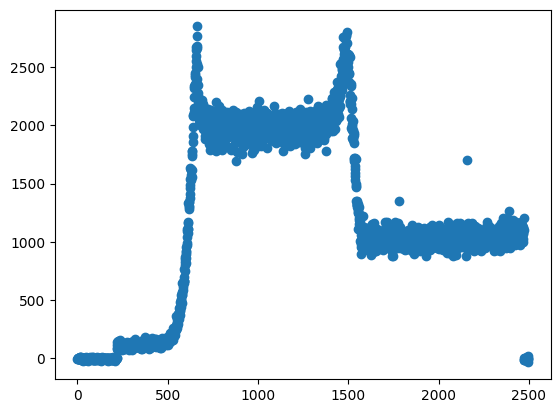

In [10]:
#If we want to detect any 'outlier'
averaged_right_overscan_rows = np.delete(averaged_right_overscan_rows, 1910, axis=1)

plt.plot(averaged_right_overscan_rows[0, ::], 'o')
plt.show()

### Now, it becomes important to remember that the whole CCD from where we have all our data sets and fits files has been irradiated with the following scheme  

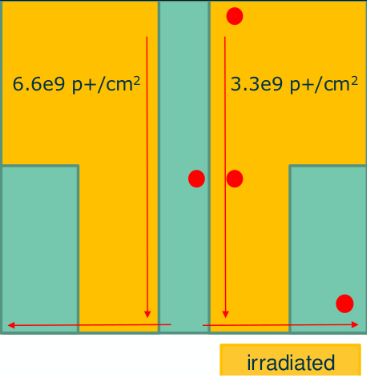

### Where we distinguish five regions, each one with a different radiation level. According to Dr. Peter Verhoeve, each  raditation region is, roughly, 900 columns wide.


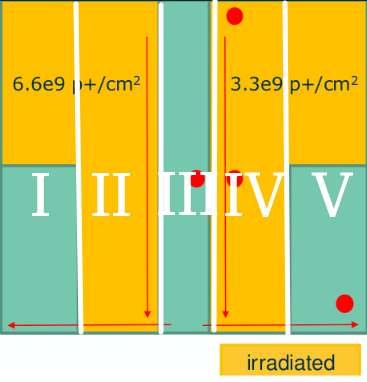


### However, if we want to avoid edges and signal intensity variations, then we can select the apppropiate  number of columns per region just by looking at our plot of the first overscan row of each CCD half, just as we did to avoid outliers. However, and as suggested by Dr. Verhoeve, using ds9 is also very helpful.

### Now it is time to do an average of the number of selected columns per region in the overscan rows. The point of this average is to have a single column per region, so we can fit a CTI model to it.  We can also have a single column for the whole left half (also for the whole right half)

In [11]:
# Let's get a single column for every radiation region we described in the figure above
cti_I     = np.mean(averaged_left_overscan_rows[:, 0:900], axis=1)
cti_II    = np.mean(averaged_left_overscan_rows[:, 1100:1800], axis=1)
cti_IV    = np.mean(averaged_right_overscan_rows[:, 750:1450], axis=1)
cti_V     = np.mean(averaged_right_overscan_rows[:, 1600:2400], axis=1)
cti_left  = np.mean(averaged_left_overscan_rows[:, :], axis = 1)
cti_right = np.mean(averaged_right_overscan_rows[:, :], axis = 1)

np.shape(cti_left)

(490,)

### Ok, so, the main varaibles are the following ones:
- left_avg : it is a 5000 x 2500 numpy array that corresponds to the average of the CCD left half of all the 24 exposures taken at a given integration time.
- rigt_avg : it is a 5000 x 2500 numpy array that corresponds to the average of the CCD right half of all the 24 exposures taken at a given integration time.

- averaged_left_overscan_rows : it is a 490 x 2500 numpy array that corresponds to the overscan rows of left_avg
- averaged_right_overscan_rows : it is a 490 x 2500 numpy array that corresponds to the overscan rows of right_avg
- cti_{i} : it is a 490 x 1 numpy array that corresponds to the average of a selected number of columns in each radiated region (in the overscan rows)

# ==============================================================

# = _________________ FITTING A MODEL TO THE DATA _______________= 

# ==============================================================

### Now it is time to fit a model to the data! What we are going to fit is a sum of inverse exponentials (a sum of damped harmonic oscilators).

In [12]:
# Let's write a CTI function to fit the data (manually)
def cti(x, a0, a1, a2, a3, b0, b1, b2, b3, c):
    f = a0 * np.exp(-b0 * x) +  a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + a3 * np.exp(-b3 * x) + c
    return f

### Now we can estimate the uncertainty of every pixel by includin some PLATO requirements and the fact that the intensity of the signal follows a Poison distribution

In [13]:
# Let's write a function to get the uncertainty of every pixel (manually)
def uncertainty(data, n_col, n_exp=24, var_photonic=None, readout_noise=35):
    var_photonic = data
    readout_noise = 35
    sigma = 1 / np.sqrt(n_col * n_exp) * np.sqrt(var_photonic + readout_noise ** 2)
    return sigma

In [14]:
# Let's obtain the uncertainty for every half of the CCD
sigma_left = uncertainty(data=cti_left, n_col=averaged_left_overscan_rows.shape[1])
sigma_right = uncertainty(data=cti_right, n_col=averaged_right_overscan_rows.shape[1])
sigma_I = uncertainty(data=cti_I, n_col=averaged_left_overscan_rows[:, 0:900].shape[1])
sigma_II = uncertainty(data=cti_II, n_col=averaged_left_overscan_rows[:, 1100:1800].shape[1])
sigma_IV = uncertainty(data=cti_IV, n_col=averaged_right_overscan_rows[:, 750:1450].shape[1])
sigma_V = uncertainty(data=cti_V, n_col=averaged_right_overscan_rows[:, 1100:1800].shape[1])

### Now we can fit our CTI function to the columns that represents the irradiated regions of the CCD

In [15]:
x = np.arange(0, 490)                                         # row index of the overscan lines
guess = [748, 397, 241, 194, 1.87, 0.353, 0.046, 0.009, 34.9] # initial guess for the parameters, from a0 to c

# Let's fit our function to the data of every CCD region
paras_I, cov_I         = curve_fit(cti, x, cti_I, bounds=(0, np.inf), maxfev=99999999, p0=guess)
paras_II, cov_II       = curve_fit(cti, x, cti_II, bounds=(0, np.inf), maxfev=99999999, p0=guess)
paras_IV, cov_IV       = curve_fit(cti, x, cti_IV, bounds=(0, np.inf), maxfev=99999999, p0=guess)
paras_V, cov_V         = curve_fit(cti, x, cti_V, bounds=(0, np.inf), maxfev=99999999, p0=guess)
paras_left, cov_left   = curve_fit(cti, x, cti_left, bounds=(0, np.inf), maxfev=99999999, p0=guess) 
paras_right, cov_right = curve_fit(cti, x, cti_right, bounds=(0, np.inf), maxfev=99999999, p0=guess)

### Now we call all the parameters of the fit in a way that is not that efficient, as follows:

In [16]:
# Let's call the parameters of the fit for every region
I_a = paras_I[0:4]
I_b = paras_I[4:8]
I_c = paras_I[8]

II_a = paras_II[0:4]
II_b = paras_II[4:8]
II_c = paras_II[8]

IV_a = paras_IV[0:4]
IV_b = paras_IV[4:8]
IV_c = paras_IV[8]

V_a = paras_V[0:4]
V_b = paras_V[4:8]
V_c = paras_V[8]

left_a = paras_left[0:4]
left_b = paras_left[4:8]
left_c = paras_left[8]

right_a = paras_right[0:4]
right_b = paras_right[4:8]
right_c = paras_right[8]

# Let's call the cti function in order to plot it using the parameters of every region
fit_cti_I       = cti(x, I_a[0], I_a[1], I_a[2], I_a[3], I_b[0], I_b[1], I_b[2], I_b[3], I_c)
fit_cti_II      = cti(x, II_a[0], II_a[1], II_a[2], II_a[3], II_b[0], II_b[1], II_b[2], II_b[3], II_c)
fit_cti_IV      = cti(x, IV_a[0], IV_a[1], IV_a[2], IV_a[3], IV_b[0], IV_b[1], IV_b[2], IV_b[3], IV_c)
fit_cti_V       = cti(x, V_a[0], V_a[1], V_a[2], V_a[3], V_b[0], V_b[1], V_b[2], V_b[3], V_c)
fit_cti_left    = cti(x, left_a[0], left_a[1], left_a[2], left_a[3], left_b[0], left_b[1], left_b[2], left_b[3], left_c)
fit_cti_right   = cti(x, right_a[0], right_a[1], right_a[2], right_a[3], right_b[0], right_b[1], right_b[2], right_b[3], right_c)

residual_I = cti_I - fit_cti_I
residual_II = cti_II - fit_cti_II
residual_IV = cti_IV - fit_cti_IV
residual_V = cti_V - fit_cti_V
residual_left = cti_left - fit_cti_left
residual_right = cti_right - fit_cti_right

### Now we plot the data, the fit and the residuals of each irradiated region

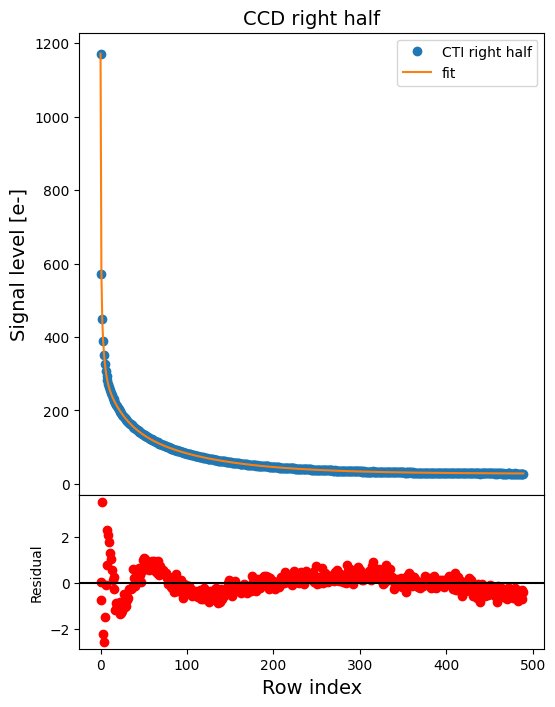

In [17]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8), gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(x, cti_right, 'o', label='CTI right half')
axs[0].plot(x, fit_cti_right, '-', label='fit')
axs[0].tick_params(axis='x', which='both', length=0)
axs[0].legend(loc='best')
axs[0].set_ylabel('Signal level [e-]', fontsize=fsize)
axs[0].set_title('CCD right half', fontsize=fsize)

axs[1].plot(x, residual_right, 'ro')
axs[1].axhline(y=0, color='black', linestyle='-')
axs[1].set_xticks([0, 100, 200, 300, 400, 500])
axs[1].set_xlabel('Row index', fontsize=fsize)
axs[1].set_ylabel('Residual')

plt.subplots_adjust(hspace=0)
plt.show()

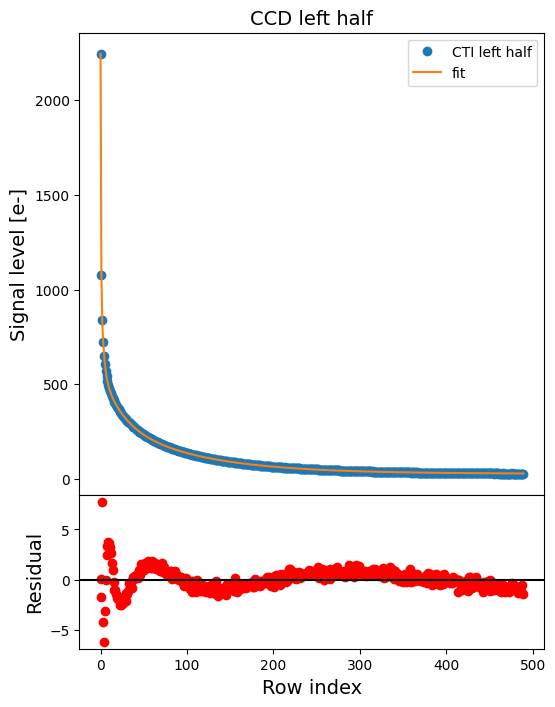

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8), gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(x, cti_left, 'o', label='CTI left half')
axs[0].plot(x, fit_cti_left, '-', label='fit')
axs[0].tick_params(axis='x', which='both', length=0)
axs[0].legend(loc='best')
axs[0].set_ylabel('Signal level [e-]', fontsize=fsize)
axs[0].set_title('CCD left half', fontsize=fsize)

axs[1].plot(x, residual_left, 'ro')
axs[1].axhline(y=0, color='black', linestyle='-')
axs[1].set_xticks([0, 100, 200, 300, 400, 500])
axs[1].set_xlabel('Row index', fontsize=fsize)
axs[1].set_ylabel('Residual', fontsize=fsize)

plt.subplots_adjust(hspace=0)
plt.show()

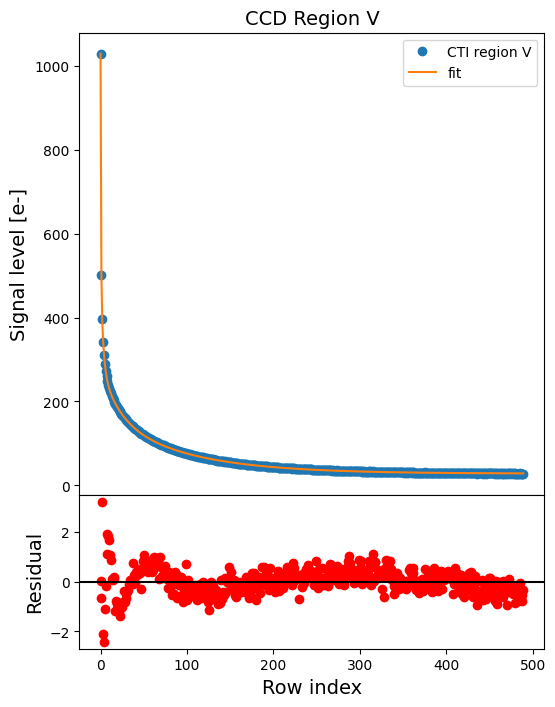

In [19]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8), gridspec_kw={'height_ratios': [3, 1]})

axs[0].plot(x, cti_V, 'o', label='CTI region V')
axs[0].plot(x, fit_cti_V, '-', label='fit')
axs[0].tick_params(axis='x', which='both', length=0)
axs[0].legend(loc='best')
axs[0].set_ylabel('Signal level [e-]', fontsize=fsize)
axs[0].set_title('CCD Region V', fontsize=fsize)

axs[1].plot(x, residual_V, 'ro')
axs[1].axhline(y=0, color='black', linestyle='-')
axs[1].set_xticks([0, 100, 200, 300, 400, 500])
axs[1].set_xlabel('Row index', fontsize=fsize)
axs[1].set_ylabel('Residual', fontsize=fsize)

plt.subplots_adjust(hspace=0)
plt.show()

In [20]:
# Let's print the values of the parameters for every region
print('\n')
print('---------------PARAMETERS OF THE FIT-----------------')
print('The A parameters for the region I are:', paras_I[0:4])
print('The A parameters for the region II are:', paras_II[0:4])
print('The A parameters for the region IV are:', paras_IV[0:4])
print('The A parameters for the region V are:', paras_V[0:4])
print('The A parameters for the left half are:', paras_left[0:4])
print('The A parameters for the right half are:', paras_right[0:4])
print('\n')

print('The b parameters for the region I are:', paras_I[4:8])
print('The b parameters for the region II are:', paras_II[4:8])
print('The b parameters for the region IV are:', paras_IV[4:8])
print('The b parameters for the region V are:', paras_V[4:8])
print('The b parameters for the left half are:', paras_left[4:8])
print('The b parameters for the right half are:', paras_right[4:8])
print('\n')

print('The smearing for the region I is:', I_c)
print('The smearing for the region II is:', II_c)
print('The smearing for the region IV is:', IV_c)
print('The smearing for the region V is:', V_c)
print('The smearing for the left half is:', left_c)
print('The smearing for the right half is:', right_c)
print('\n')

print('The trap release constant for the region I is:', (1 / paras_I[4:8]) * (4/5000))
print('The trap release constant for the region II is:', ( 1 / paras_II[4:8]) * (4/5000))
print('The trap release constant for the region IV is:', 1 / paras_IV[4:8] * (4/5000))
print('The trap release constant for the region V is:', (1 / paras_V[4:8]) * (4/5000))
print('The trap release constant for the left half is:', (1 / paras_left[4:8]) * (4/5000))
print('The trap release constant for the right half is:', (1 / paras_right[4:8]) * (4/5000))



---------------PARAMETERS OF THE FIT-----------------
The A parameters for the region I are: [936.74543083 424.11676286 205.87413072 254.07170266]
The A parameters for the region II are: [2062.38584708  936.45394842  464.40440848  541.47572284]
The A parameters for the region IV are: [990.57423605 461.29376484 227.68738087 272.52011226]
The A parameters for the region V are: [504.40858843 240.17260109 113.58814547 142.84608893]
The A parameters for the left half are: [1140.26903603  518.46002049  254.88321902  303.8575825 ]
The A parameters for the right half are: [577.27793212 272.9677119  131.74482889 162.18674697]


The b parameters for the region I are: [2.09421829 0.35403535 0.04694683 0.01061613]
The b parameters for the region II are: [2.06126444 0.34983346 0.04499772 0.01031257]
The b parameters for the region IV are: [2.08577389 0.35964801 0.04703266 0.01065723]
The b parameters for the region V are: [2.14698903 0.368408   0.04983011 0.01108182]
The b parameters for the left

In [21]:
#Let's make a class with different versions of the cti functions
class CTIFunction:
    def __init__(self, num_terms):
        self.num_terms = num_terms
        self.params = None
        
    def cti(self, x, *args):
        a = args[:self.num_terms]
        b = args[self.num_terms:2*self.num_terms]
        c = args[2*self.num_terms]
        f = np.sum([a[i] * np.exp(-b[i] * x) for i in range(self.num_terms)], axis=0) + c
        return f
        
    def fit(self, x, y, bounds, sigma, guess=None):
        self.params, cov = curve_fit(self.cti, x, y, bounds=bounds, maxfev=99999999, sigma=sigma, p0=guess)
        return self.params, cov
    
    def reduced_chi_square(self, y, sigma, num_terms):
        fit = self.cti(x, *self.params)
        chi_square = np.sum(((y - fit)/ sigma) ** 2)
        degrees_freedom = len(y) - num_terms
        red_chi_square = chi_square / degrees_freedom
        return red_chi_square

    
    def plot_fit(self, x, y, sigma, s):
        if self.params is None:
            raise ValueError("Fit parameters are not available. Fit the data first.")

        fit = self.cti(x, *self.params)
        residuals = (y - fit) / sigma

        fig, axs = plt.subplots(2, 3, sharex=True, figsize=(6, 8), gridspec_kw={'height_ratios': [3, 1]})
        fig.suptitle(s, fontsize=16)  # Add a common title

        axs[0, 0].plot(x, y, 'o', label='Data')
        axs[0, 0].plot(x, fit, '-', label='Fit')
        axs[0, 0].tick_params(axis='x', which='both', length=0)
        axs[0, 0].legend(loc='best')
        axs[0, 0].set_ylabel('Signal level [e-]')

        axs[1, 0].plot(x, residuals, 'ro')
        axs[1, 0].axhline(y=0, color='black', linestyle='-')
        axs[1, 0].set_xticks([0, 250, 500])
        axs[1, 0].set_xlabel('Row index')
        axs[1, 0].set_ylabel('Weighted Residual')

        axs[0, 1].plot(x, y, 'o', label='Data')
        axs[0, 1].plot(x, fit, '-', label='Fit')
        axs[0, 1].tick_params(axis='x', which='both', length=0)
        axs[0, 1].legend(loc='best')

        axs[1, 1].plot(x, residuals*sigma, 'ro')
        axs[1, 1].axhline(y=0, color='black', linestyle='-')
        axs[1, 1].set_xticks([0, 250, 500])
        axs[1, 1].set_xlabel('Row index')
        axs[1, 1].set_ylabel('Residual')

        axs[0, 2].plot(x, y, 'o', label='Data')
        axs[0, 2].plot(x, fit, '-', label='Fit')
        axs[0, 2].tick_params(axis='x', which='both', length=0)
        axs[0, 2].legend(loc='best')

        axs[1, 2].plot(x, residuals*sigma, 'ro')
        axs[1, 2].plot(x, sigma, 'g^')
        axs[1, 2].axhline(y=0, color='black', linestyle='-')
        axs[1, 2].set_xticks([0, 250, 500])
        axs[1, 2].set_xlabel('Row index')
        axs[1, 2].set_ylabel('Residual & noise')


        plt.subplots_adjust(wspace=0.7, hspace=0.05)
        plt.show()
        

2.018021557546553


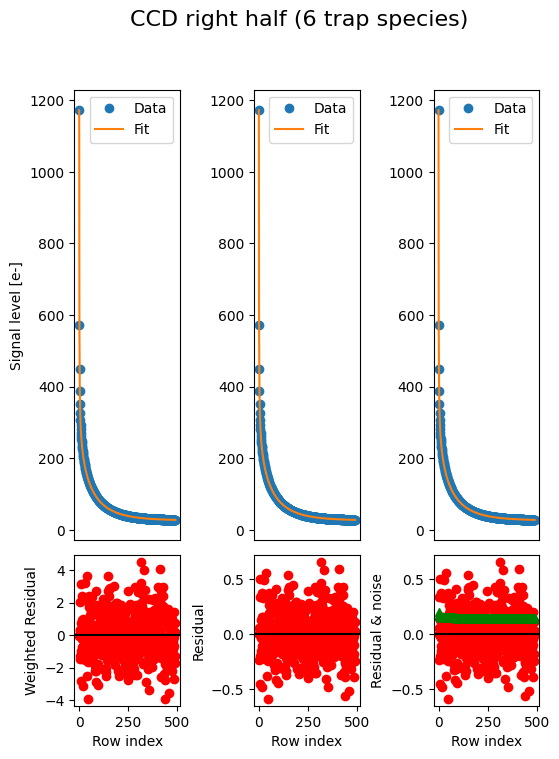

In [22]:
# Manually specify the guess parameter
#guess_r = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_r = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_r = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_r = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras_r, cov_r = cti.fit(x, cti_right, bounds=(0, np.inf), sigma=sigma_right, guess=guess_r)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_right, sigma_right, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x=x, y=cti_right, sigma=sigma_right, s='CCD right half (6 trap species)')

56.10599832085533


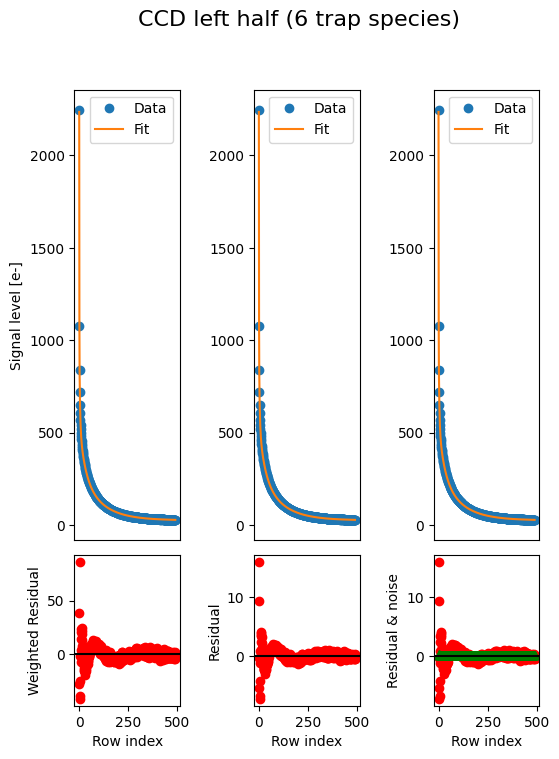

In [23]:
# Manually specify the guess parameter
#guess_l = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_l = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_l = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_l = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras, cov = cti.fit(x, cti_left, bounds=(0, np.inf), sigma=sigma_left, guess=guess_l)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_left, sigma_left, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x, cti_left, sigma_left, 'CCD left half (6 trap species)')

2.5810099746987882


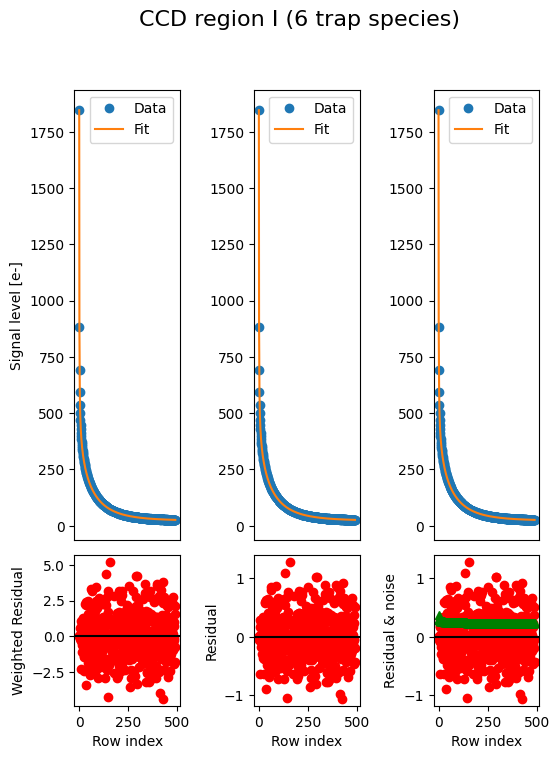

In [24]:
# Manually specify the guess parameter
#guess_i = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_i = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_i = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_i = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras_i, cov_i = cti.fit(x, cti_I, bounds=(0, np.inf), sigma=sigma_I, guess=guess_i)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_I, sigma_I, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x, cti_I, sigma_I, 'CCD region I (6 trap species)')

1.9513559978650834


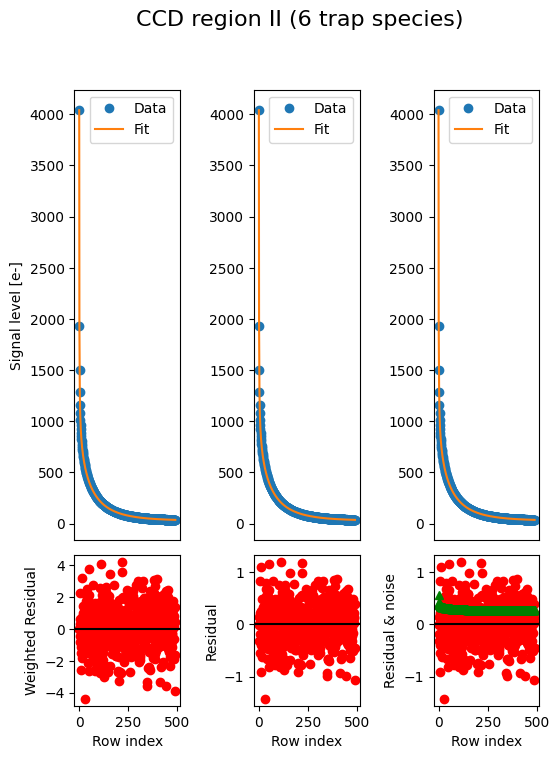

In [25]:
# Manually specify the guess parameter
#guess_ii = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_ii = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_ii = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_ii = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras_ii, cov_ii = cti.fit(x, cti_II, bounds=(0, np.inf), sigma=sigma_II, guess=guess_ii)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_II, sigma_II, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x, cti_II, sigma_II, 'CCD region II (6 trap species)')

1.2191265369123656


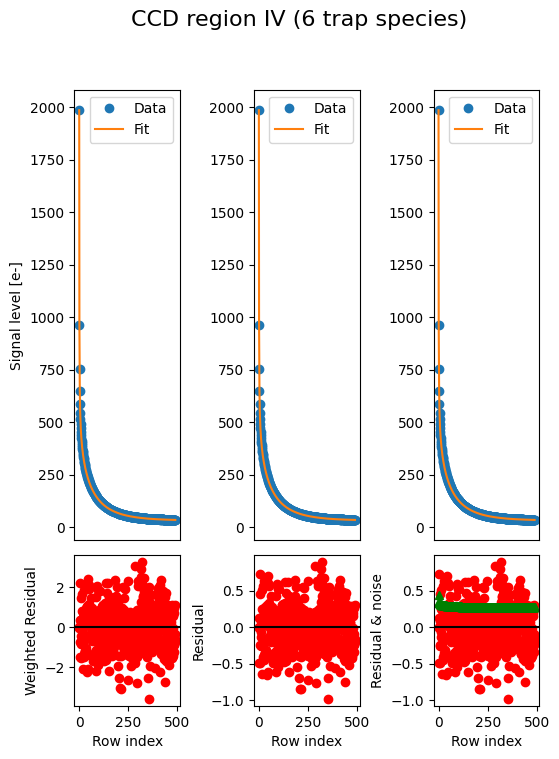

In [26]:
# Manually specify the guess parameter
#guess_iv = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_iv = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_iv = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_iv = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras_iv, cov_iv = cti.fit(x, cti_IV, bounds=(0, np.inf), sigma=sigma_IV, guess=guess_iv)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_IV, sigma_IV, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x, cti_IV, sigma_IV, 'CCD region IV (6 trap species)')

1.27016068095169


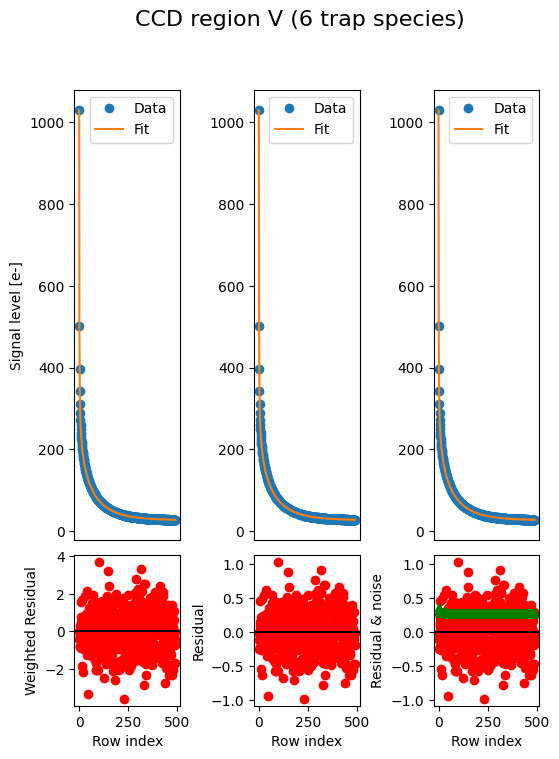

In [27]:
# Manually specify the guess parameter
#guess_v = [1500, 500, 241, 154, 1.87, 0.353, 0.046, 0.009, 34.9]
#guess_v = [1500, 500, 241, 154, 99, 1.87, 0.353, 0.046, 0.009, 0.001, 34.9]
guess_v = [1500, 500, 241, 154, 99, 10, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 34.9]
#guess_v = [1500, 500, 241, 154, 99, 10, 1, 1.87, 0.353, 0.046, 0.009, 0.001, 0.0006, 0.0001, 34.9]
# Create an instance of CTIFunction
cti = CTIFunction(num_terms=6)

# Fit the data using the specified guess parameter
paras_v, cov_v = cti.fit(x, cti_V, bounds=(0, np.inf), sigma=sigma_V, guess=guess_v)

# Compute the reduced chi square
red_chi_2 = cti.reduced_chi_square(cti_V, sigma_V, 6)
print(red_chi_2)

# Plot the fit alongside the data with residuals
cti.plot_fit(x, cti_V, sigma_V, 'CCD region V (6 trap species)')

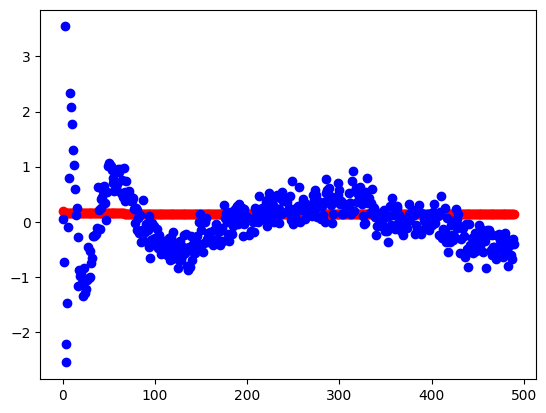

In [28]:
plt.plot(sigma_right, 'ro')
plt.plot(residual_right, 'bo')

In [29]:
# Let's compute the trap release time constants
paras_ii

array([1.42230708e+03, 1.09355469e+03, 4.50042441e+02, 4.03087309e+02,
       3.54090042e+02, 2.86473617e+02, 3.24730691e+00, 8.07859610e-01,
       2.53652150e-01, 2.15462414e-02, 8.24072788e-03, 7.33615891e-02,
       3.02529169e+01])

In [30]:
paras_ii[5:10]

array([2.86473617e+02, 3.24730691e+00, 8.07859610e-01, 2.53652150e-01,
       2.15462414e-02])

In [31]:
paras_r

array([4.06835842e+02, 2.94892892e+02, 1.27996371e+02, 1.07465235e+02,
       1.21142132e+02, 8.67704587e+01, 3.24200449e+00, 8.22144511e-01,
       2.95189984e-01, 2.53051784e-02, 9.38807673e-03, 8.90039366e-02,
       2.66815185e+01])

In [32]:
paras_r[6:12]

array([3.24200449, 0.82214451, 0.29518998, 0.02530518, 0.00938808,
       0.08900394])

In [33]:
np.round((1 / paras_ii[5:10]) * (0.00092243), 6)

array([3.0000e-06, 2.8400e-04, 1.1420e-03, 3.6370e-03, 4.2812e-02])

In [34]:
np.round((1 / paras_r[6:12]) * (0.00092243), 6)

array([0.000285, 0.001122, 0.003125, 0.036452, 0.098255, 0.010364])